In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

In [2]:
mandate = .1

In [3]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [4]:
%%bigquery van_targets --project rugged-baton-283921
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 AND co2Emissions = 0))
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make

Downloading: 100%|██████████| 58/58 [00:01<00:00, 56.54rows/s]


In [5]:
# car_targets.sort_values('meanCo2').plot(kind='bar', x='make', figsize=(40, 10))

In [6]:
%%bigquery df_activity --project rugged-baton-283921
SELECT 
    make, 
    COUNT(*) as totalSales,
    COUNTIF(co2Emissions > 0) as nonzevSales,
    COUNTIF(co2Emissions = 0) as zevSales,
    SUM(co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)
GROUP BY make
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 16/16 [00:00<00:00, 16.37rows/s]


In [7]:
dfa = df_activity.merge(van_targets, how='left', on='make')
dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [8]:
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits


In [9]:
dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


In [10]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances
0,MAN,2680,2599,80,632840.0,543.085422,1.411479e+06,7.786390e+05,67.000000
1,RENAULT TRUCKS,2738,1476,89,909839.0,504.247436,7.442692e+05,-1.655698e+05,0.000000
2,LAND ROVER,2921,2921,0,671241.0,243.045704,7.099365e+05,3.869550e+04,73.025000
3,FIAT,4074,3798,276,721116.0,213.252940,8.099347e+05,8.881867e+04,101.850000
4,MAXUS,4080,1730,2344,523322.0,303.998630,5.259176e+05,2.595629e+03,15.542689
5,IVECO,4150,3324,5,1119467.0,558.126724,1.855213e+06,7.357462e+05,103.750000
6,ISUZU,4298,4293,0,976898.0,268.672012,1.153409e+06,1.765109e+05,107.450000
7,NISSAN,4761,4344,51,971307.0,230.811389,1.002645e+06,3.133767e+04,119.025000
8,TOYOTA,13051,11941,1108,2511236.0,220.195229,2.629351e+06,1.181152e+05,326.275000
9,PEUGEOT,19012,15911,3086,3016867.0,183.066115,2.912765e+06,-1.041020e+05,0.000000


In [11]:
# mandate = .1 Defined above
dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

AttributeError: 'Series' object has no attribute 'proposed_co2_to_mandate_allowances'

In [ ]:
(1 - (mandate * .25)) * 135525

In [ ]:
dfa[dfa.make == 'VOLKSWAGEN']

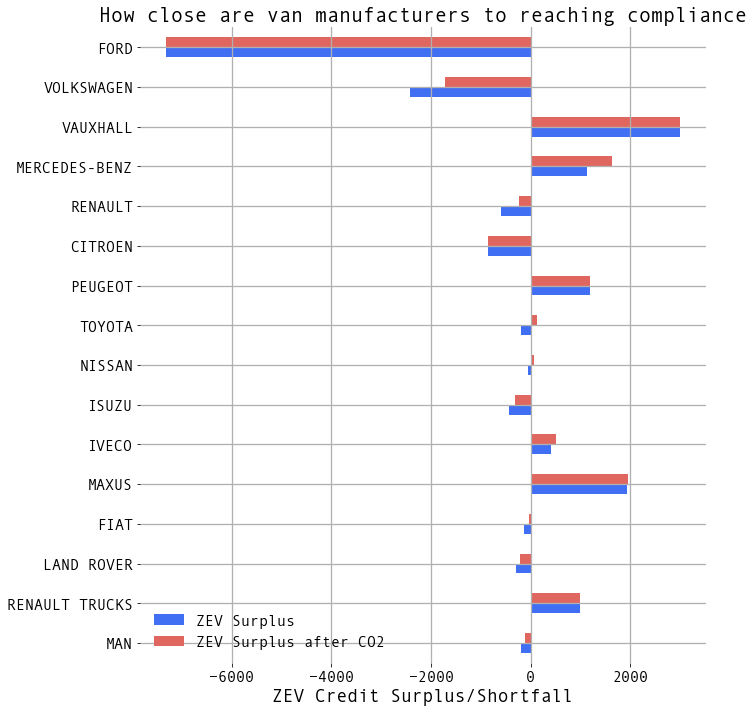

In [12]:
fig, ax = plt.subplots()

dfa.plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('How close are van manufacturers to reaching compliance')

plt.savefig('plots/van_top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [13]:
dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [14]:
dfa_sel = dfa[[
    'make',
    'totalSales',
    'nonzevSales',
    'zevSales',
    'co2Target',
    'CO2 Performance',
    'ZEVMallowances',
    'ZEV Surplus',
    'ZEV Surplus after CO2'
]].rename(columns={
    'make': 'Make',
    'totalSales': 'Total Sales',
    'co2Target': 'CO2 Target',
    'nonzevSales': 'Non-ZEV Sales',
    'zevSales': 'ZEV Sales',
    'ZEVMallowances': 'Allocated allowances',
    'ZEV Surplus': 'Allowance Surplus',
    'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
})

# dfa_sel['Mean CO2'] = 
dfa_sel = round(dfa_sel, ndigits=2)

dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [15]:
dfa_sel.to_csv('van_ZEV_compliance_tracker.csv')

# Rolling Performance

In [16]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 587/587 [00:00<00:00, 654.07rows/s] 


In [17]:
df_act

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,5,5,0,1010.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,LAND ROVER,2020-08-01 00:00:00+00:00,19,19,0,3842.0
3,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0
4,LAND ROVER,2020-05-01 00:00:00+00:00,19,19,0,3834.0
...,...,...,...,...,...,...
582,FORD,2022-09-01 00:00:00+00:00,13060,12768,292,2785343.0
583,FORD,2023-03-01 00:00:00+00:00,15269,14828,293,3147885.0
584,FORD,2022-03-01 00:00:00+00:00,16557,16554,3,3485470.0
585,FORD,2020-09-01 00:00:00+00:00,18145,18145,0,3093947.0


In [18]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [19]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [20]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,5,5,0,1010.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,LAND ROVER,2020-08-01 00:00:00+00:00,19,19,0,3842.0
3,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0
4,LAND ROVER,2020-05-01 00:00:00+00:00,19,19,0,3834.0


In [21]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [22]:
df

,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make
11,2021-03-01 00:00:00+00:00,1392.0,1390.0,2.0,303028.0,LAND ROVER
12,2021-04-01 00:00:00+00:00,1816.0,1814.0,2.0,406813.0,LAND ROVER
13,2021-05-01 00:00:00+00:00,2088.0,2086.0,2.0,473503.0,LAND ROVER
14,2021-06-01 00:00:00+00:00,2309.0,2306.0,3.0,531188.0,LAND ROVER
15,2021-07-01 00:00:00+00:00,2444.0,2441.0,3.0,570970.0,LAND ROVER
...,...,...,...,...,...,...
32,2022-12-01 00:00:00+00:00,20720.0,18218.0,1896.0,6100197.0,MERCEDES-BENZ
33,2023-01-01 00:00:00+00:00,20542.0,17836.0,1947.0,5514809.0,MERCEDES-BENZ
34,2023-02-01 00:00:00+00:00,20140.0,17406.0,1786.0,5147987.0,MERCEDES-BENZ
35,2023-03-01 00:00:00+00:00,20417.0,17481.0,1455.0,4866636.0,MERCEDES-BENZ


In [23]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(van_targets, how='left', on='make')

In [24]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)
df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# df['proposed_co2_to_mandate_allowances'] = df.apply(lambda row: proposed_co2_to_zev(row,), axis=1)

In [25]:
df.head()

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances
0,11,2021-03-01 00:00:00+00:00,1392.0,1390.0,2.0,303028.0,LAND ROVER,243.045704,337833.528336,34805.528336,34.800
1,12,2021-04-01 00:00:00+00:00,1816.0,1814.0,2.0,406813.0,LAND ROVER,243.045704,440884.906764,34071.906764,45.400
2,13,2021-05-01 00:00:00+00:00,2088.0,2086.0,2.0,473503.0,LAND ROVER,243.045704,506993.338208,33490.338208,52.200
3,14,2021-06-01 00:00:00+00:00,2309.0,2306.0,3.0,531188.0,LAND ROVER,243.045704,560463.393053,29275.393053,57.725
4,15,2021-07-01 00:00:00+00:00,2444.0,2441.0,3.0,570970.0,LAND ROVER,243.045704,593274.563071,22304.563071,61.100


In [26]:

df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [27]:
df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')

make,CITROEN,FIAT,FORD,ISUZU,IVECO,LAND ROVER,MAN,MAXUS,MERCEDES-BENZ,NISSAN,PEUGEOT,RENAULT,RENAULT TRUCKS,TOYOTA,VAUXHALL,VOLKSWAGEN
monthOfFirstRegistration,,,,,,,,,,,,,,,,
2021-03-01 00:00:00+00:00,584.575000,132.025000,2579.100000,65.250000,62.600000,34.800000,7.580000e+01,NaN,8.003750e+02,252.650000,626.175000,3.172750e+02,40.150,235.675000,0.000000e+00,823.175000
2021-04-01 00:00:00+00:00,644.150000,144.475000,2811.750000,72.350000,69.975000,45.400000,8.280000e+01,NaN,8.398250e+02,281.050000,677.950000,3.424250e+02,43.275,263.200000,0.000000e+00,892.250000
2021-05-01 00:00:00+00:00,700.550000,153.400000,2985.775000,78.150000,78.725000,52.200000,8.642500e+01,NaN,8.580000e+02,303.575000,716.025000,3.717500e+02,46.825,284.175000,0.000000e+00,957.625000
2021-06-01 00:00:00+00:00,690.500000,157.275000,2960.725000,83.150000,89.800000,57.725000,8.822500e+01,NaN,8.467000e+02,302.275000,725.850000,4.015000e+02,50.325,289.350000,0.000000e+00,994.125000
2021-07-01 00:00:00+00:00,685.975000,154.900000,2957.300000,81.725000,96.250000,61.100000,8.767500e+01,NaN,8.136500e+02,296.125000,716.025000,3.860000e+02,52.300,282.200000,0.000000e+00,985.400000
2021-08-01 00:00:00+00:00,684.925000,152.475000,3038.275000,83.500000,0.000000,62.850000,8.177500e+01,0.000000,7.651250e+02,297.800000,695.225000,3.783000e+02,53.250,294.150000,0.000000e+00,978.425000
2021-09-01 00:00:00+00:00,625.450000,43.198280,2875.850000,80.700000,0.000000,65.625000,7.830000e+01,0.000000,7.706750e+02,268.375000,641.500000,3.809000e+02,52.550,300.525000,0.000000e+00,894.525000
2021-10-01 00:00:00+00:00,638.375000,0.000000,2924.750000,79.650000,0.000000,49.324448,7.335000e+01,0.000000,7.488000e+02,255.315290,644.500000,3.896750e+02,54.525,298.588668,9.838248e+01,844.825000
2021-11-01 00:00:00+00:00,578.418635,0.000000,2665.680762,8.972111,0.000000,16.092491,5.066502e+00,0.000000,7.358750e+02,182.840747,508.571139,2.675372e+02,55.450,118.975879,3.418652e+02,645.628902


In [28]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

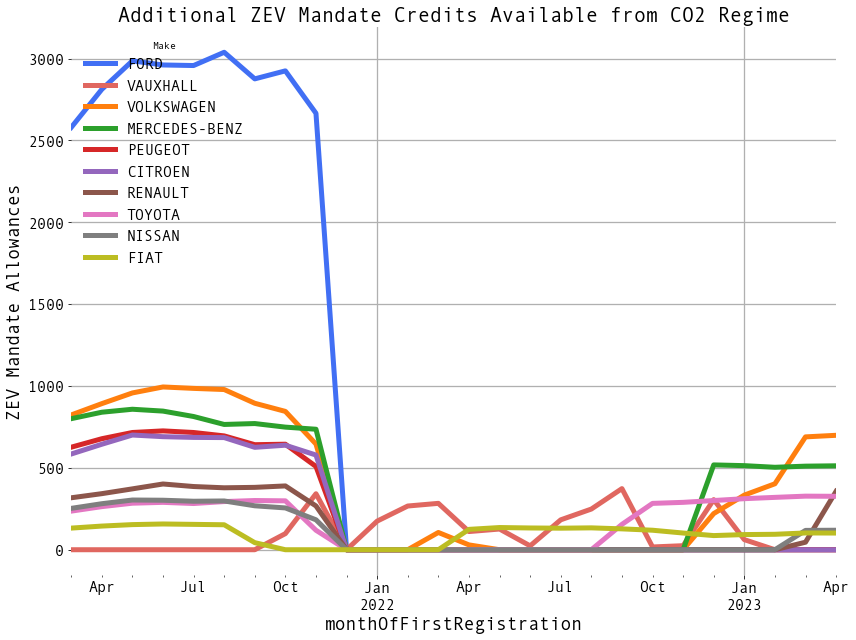

In [29]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

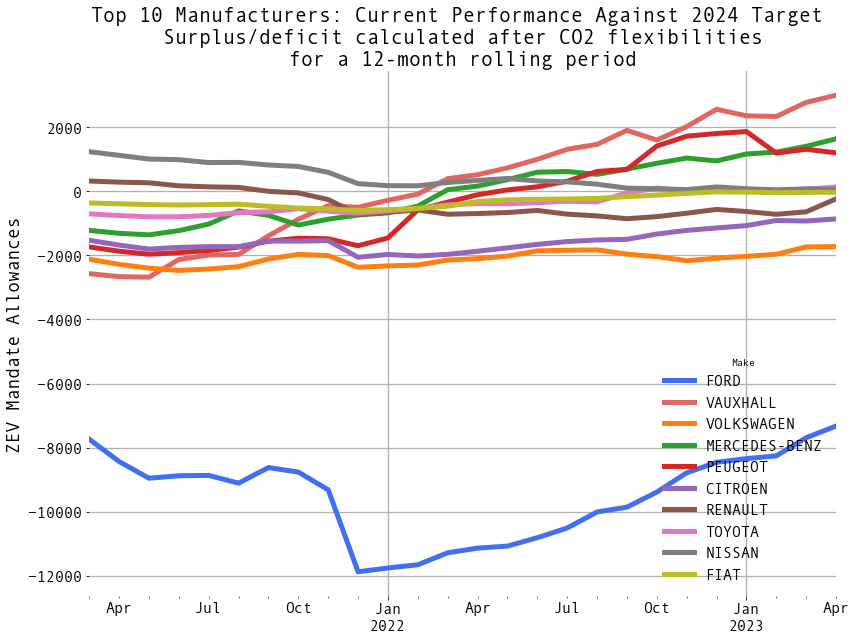

In [30]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

# plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [31]:
dfa['ZEV Surplus after CO2']

0     -120.000000
1      988.200000
2     -219.075000
3      -29.550000
4     1957.542689
5      514.750000
6     -317.350000
7       59.925000
8      131.175000
9     1199.800000
10    -861.100000
11    -235.038401
12    1638.500000
13    2999.700000
14   -1723.625000
15   -7327.000000
Name: ZEV Surplus after CO2, dtype: float64

<AxesSubplot:xlabel='monthOfFirstRegistration'>

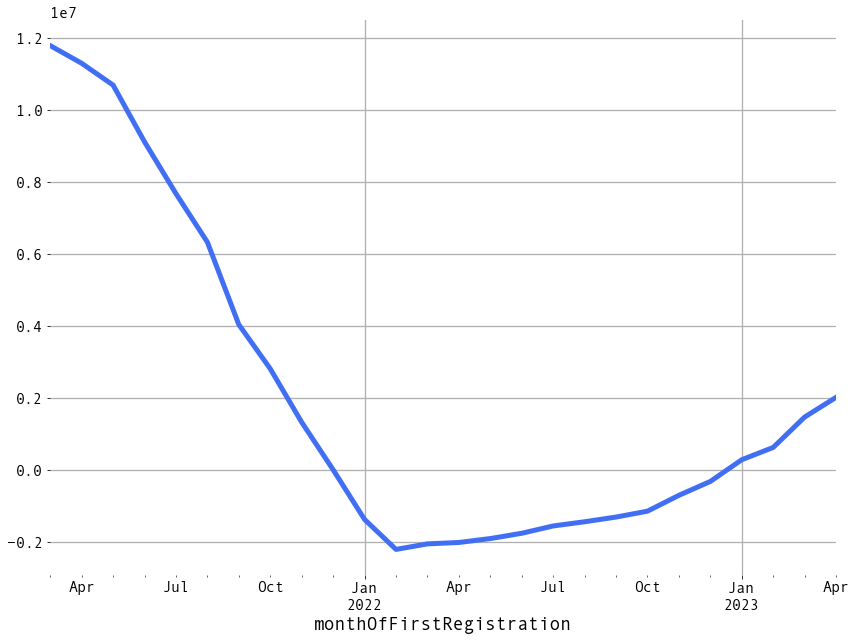

In [32]:
df.groupby(['monthOfFirstRegistration']).sum().co2Compliance.plot()

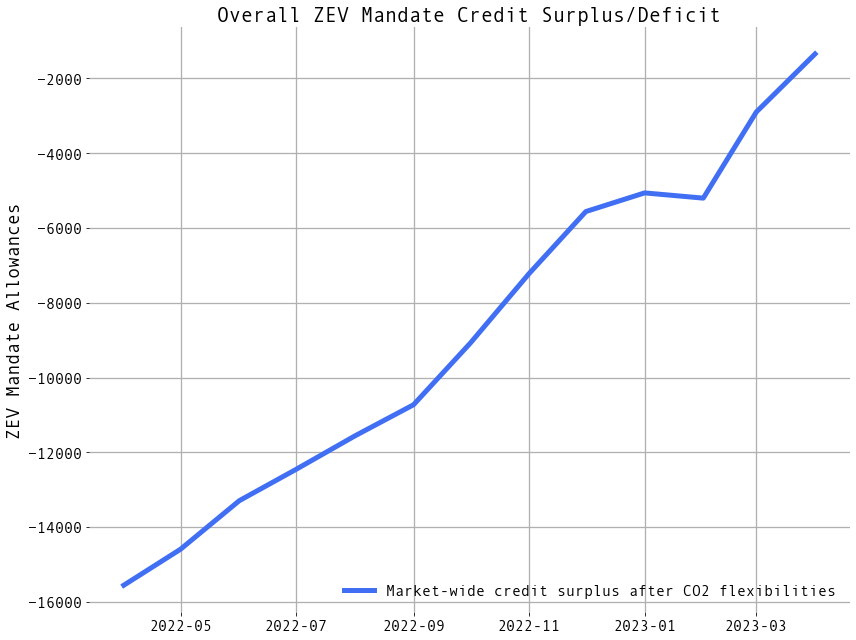

In [33]:
fig, ax = plt.subplots()

plt_df = df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2']

# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
ax.plot(plt_df[plt_df.index > '2022-03-01'], label='Market-wide credit surplus after CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Credit Surplus/Deficit')

plt.savefig('plots/van_aggregate_demand_credits.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [34]:
plt_df

monthOfFirstRegistration
2021-03-01 00:00:00+00:00   -17119.775000
2021-04-01 00:00:00+00:00   -18776.625000
2021-05-01 00:00:00+00:00   -19973.700000
2021-06-01 00:00:00+00:00   -19386.375000
2021-07-01 00:00:00+00:00   -18993.375000
2021-08-01 00:00:00+00:00   -18132.525000
2021-09-01 00:00:00+00:00   -16730.926720
2021-10-01 00:00:00+00:00   -16364.739111
2021-11-01 00:00:00+00:00   -16710.325438
2021-12-01 00:00:00+00:00   -21333.869141
2022-01-01 00:00:00+00:00   -20343.190494
2022-02-01 00:00:00+00:00   -18759.487014
2022-03-01 00:00:00+00:00   -16635.675594
2022-04-01 00:00:00+00:00   -15556.210920
2022-05-01 00:00:00+00:00   -14592.009087
2022-06-01 00:00:00+00:00   -13294.707240
2022-07-01 00:00:00+00:00   -12456.168697
2022-08-01 00:00:00+00:00   -11562.527532
2022-09-01 00:00:00+00:00   -10728.248337
2022-10-01 00:00:00+00:00    -9078.451031
2022-11-01 00:00:00+00:00    -7220.046025
2022-12-01 00:00:00+00:00    -5559.841062
2023-01-01 00:00:00+00:00    -5061.309274
2023-02-0

In [35]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

In [36]:
van_targets[van_targets.make.isin(top_makes)]

,make,co2Target
0,FIAT,213.252940
1,VAUXHALL,190.108331
2,VOLKSWAGEN,201.449841
10,MERCEDES-BENZ,342.806124
19,FORD,203.275600
20,RENAULT,215.645457
21,NISSAN,230.811389
32,TOYOTA,220.195229
42,CITROEN,180.890005
43,PEUGEOT,183.066115


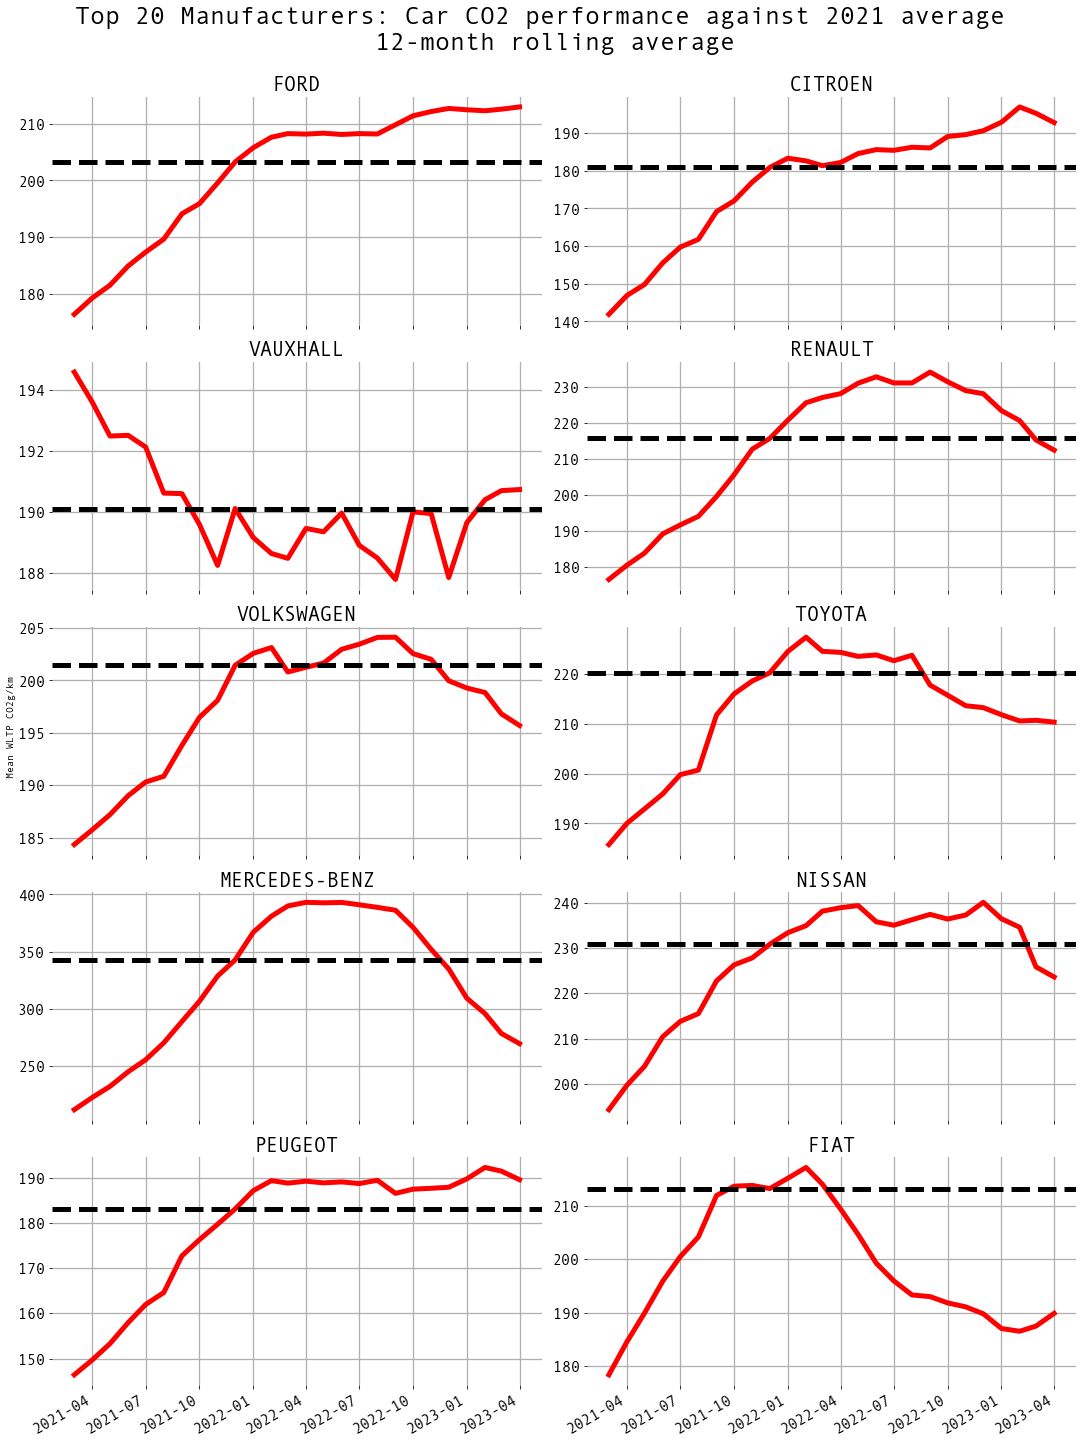

In [37]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/van_co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]